# Single Model Training

This notebook is to enable model training for a single model using the specified parameters in config.yaml.


In [25]:
# Import required libraries
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..",))
sys.path.append(project_root)
from src.pipelines.xgboost.train_single_model import main

## 1. Run Model

In [26]:
# Now you can import from core if needed
from src.core.clients.bigquery import BigQueryClient
from src.core.config_loader import ConfigLoader

bq_client = BigQueryClient()
config_loader = ConfigLoader()

sales_query = f"""
    SELECT 
    *  
    FROM `porygon-pipelines.walmart_training_tables.walmart_master_table` tgt
    WHERE 
        tgt.ctx_store_id = 'CA_1'
        AND is_stockout_tgt = 0
"""


# Extract data
df = bq_client.load_from_query(sales_query)


INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 148964 rows from custom query.


INFO:src.pipelines.xgboost.train_single_model:
        XGBoost Model Training Pipeline is starting...
        
INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
INFO:src.core.clients.bigquery:Loaded 148964 rows from table: walmart_master_table
INFO:src.pipelines.xgboost.train_single_model:Filtering outliers ...
INFO:src.pipelines.xgboost.train_single_model:Training model...
INFO:src.core.models.xgboost:
            Training XGBoost Model...
            


[0]	validation_0-rmse:2.10846	validation_1-rmse:1.55525
[1]	validation_0-rmse:2.09322	validation_1-rmse:1.54323
[2]	validation_0-rmse:2.08402	validation_1-rmse:1.53460
[3]	validation_0-rmse:2.07290	validation_1-rmse:1.52720
[4]	validation_0-rmse:2.06493	validation_1-rmse:1.50393
[5]	validation_0-rmse:2.06127	validation_1-rmse:1.49687
[6]	validation_0-rmse:2.05702	validation_1-rmse:1.49001
[7]	validation_0-rmse:2.04603	validation_1-rmse:1.45773
[8]	validation_0-rmse:2.03968	validation_1-rmse:1.47554
[9]	validation_0-rmse:2.03660	validation_1-rmse:1.47698
[10]	validation_0-rmse:2.03569	validation_1-rmse:1.48529
[11]	validation_0-rmse:2.03299	validation_1-rmse:1.47752
[12]	validation_0-rmse:2.03215	validation_1-rmse:1.48922
[13]	validation_0-rmse:2.03036	validation_1-rmse:1.48556
[14]	validation_0-rmse:2.03013	validation_1-rmse:1.48698
[15]	validation_0-rmse:2.02907	validation_1-rmse:1.49419
[16]	validation_0-rmse:2.02862	validation_1-rmse:1.49737
[17]	validation_0-rmse:2.02848	validation

INFO:src.core.models.xgboost:Model saved to /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260123_143755/model_0.joblib
INFO:src.core.models.xgboost:
            Model Training Pipeline completed successfully!
            Run ID: /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260123_143755
            Artifacts saved to: /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260123_143755
            


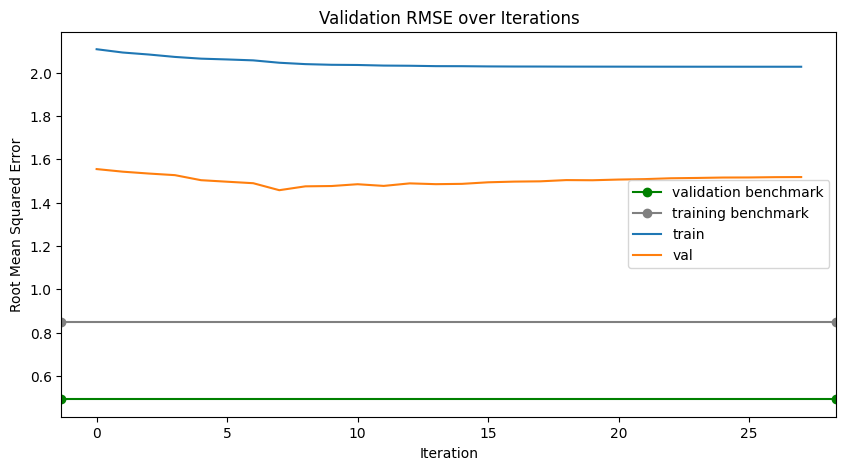

In [27]:
features = [
    c for c in 
    df if "fea_" in c
]
trained_model = main(features = features)

## 2. Compare metrics with Benchmark

1. Compare Metrics (MdAPE, MdAE) with benchmark in total and accross validation sets of interest

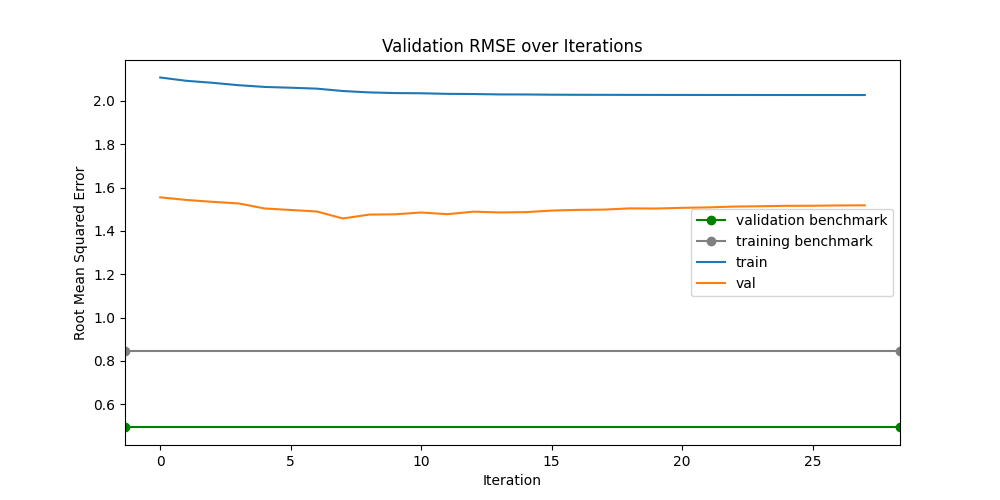

In [28]:
from IPython.display import Image, display
display(Image(trained_model.plot_bias_variance_tradeoff_path))

## 6. Evaluate Residuals

In [29]:
from src.core.transformations.transformations import apply_log_normal_transformation

df = apply_log_normal_transformation(df, target_col ="tgt_benchmark")
df = apply_log_normal_transformation(df)

In [30]:
from src.core.transformations.transformations import split_dataset
from sklearn.metrics import root_mean_squared_error

# Split dataframes
training_df, validation_df = split_dataset(loaded_df= df)
benchmark = root_mean_squared_error(validation_df[config_loader.target_col], validation_df["tgt_benchmark"])

In [31]:
import matplotlib.pyplot as plt
predictions = trained_model.model.predict(validation_df[features])
residuals = validation_df[config_loader.target_col] - predictions
bench_residuals = validation_df[config_loader.target_col] - validation_df["tgt_benchmark"]

In [32]:
%matplotlib inline

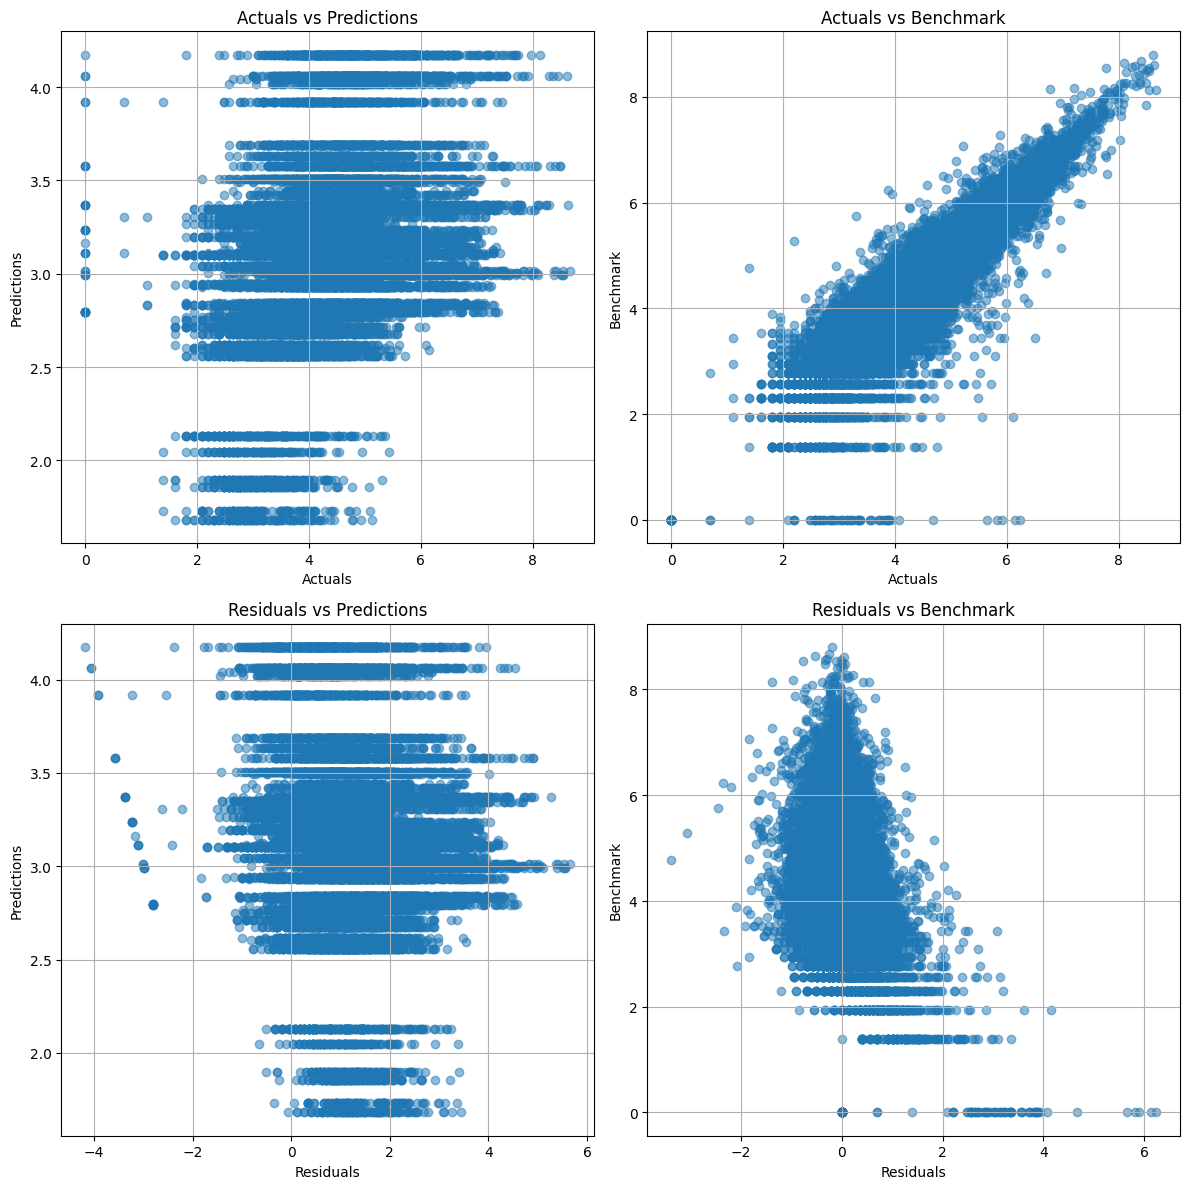

In [33]:
fig, axs = plt.subplots(2,2, figsize=(12,12))

# Actuals vs Predictions
axs[0,0].scatter(validation_df[config_loader.target_col], predictions, alpha = 0.5)
axs[0,0].set_xlabel("Actuals")
axs[0,0].set_ylabel("Predictions")
axs[0,0].set_title("Actuals vs Predictions")
axs[0,0].grid(True)

# Actuals vs Benchmark
axs[0,1].scatter(validation_df[config_loader.target_col], validation_df["tgt_benchmark"], alpha = 0.5)
axs[0,1].set_xlabel("Actuals")
axs[0,1].set_ylabel("Benchmark")
axs[0,1].set_title("Actuals vs Benchmark")
axs[0,1].grid(True)

# Residuals vs Predictions
axs[1,0].scatter(residuals, predictions, alpha = 0.5)
axs[1,0].set_xlabel("Residuals")
axs[1,0].set_ylabel("Predictions")
axs[1,0].set_title("Residuals vs Predictions")
axs[1,0].grid(True)

# Residuals vs Benchamrk
axs[1,1].scatter(bench_residuals, validation_df["tgt_benchmark"], alpha = 0.5)
axs[1,1].set_xlabel("Residuals")
axs[1,1].set_ylabel("Benchmark")
axs[1,1].set_title("Residuals vs Benchmark")
axs[1,1].grid(True)

plt.tight_layout()
plt.show()

## 8. Feature Importance

In [36]:
trained_model.feature_importance

,feature,importance
5,fea_is_event_3m,301.0
3,fea_dept_number,275.0
4,fea_is_weekend_3m,167.0
7,fea_is_cultural_event_3m,148.0
0,fea_is_foods,115.0
1,fea_is_hobbies,105.0
2,fea_is_household,74.0
6,fea_is_sporting_event_3m,54.0
8,fea_is_national_event_3m,51.0


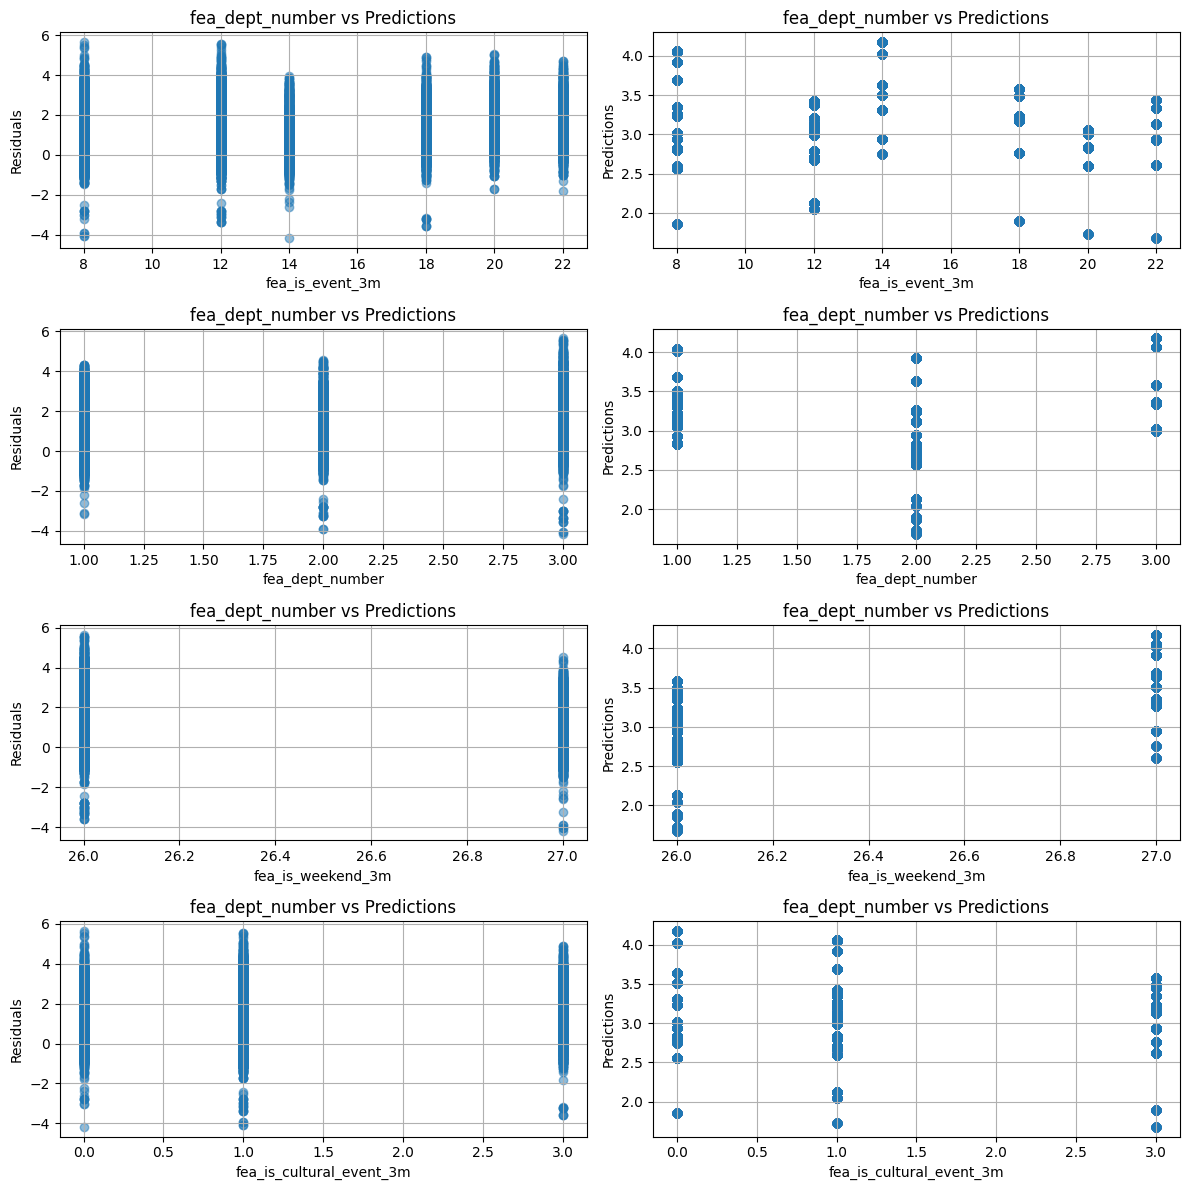

In [35]:
top_importance = trained_model.feature_importance[:4]
fig, axs = plt.subplots(len((top_importance["feature"].to_list())),2, figsize=(12,12))

for ax_index, feature in zip(range(len((top_importance["feature"].to_list()))), trained_model.feature_importance["feature"].to_list()):
    # Feature vs Residual
    axs[ax_index, 0].scatter(validation_df[feature], residuals, alpha = 0.5)
    axs[ax_index, 0].set_xlabel(feature)
    axs[ax_index, 0].set_ylabel("Residuals")
    axs[ax_index, 0].set_title("fea_dept_number vs Predictions")
    axs[ax_index, 0].grid(True)

    # Feature vs Prediction
    axs[ax_index, 1].scatter(validation_df[feature], predictions, alpha = 0.5)
    axs[ax_index, 1].set_xlabel(feature)
    axs[ax_index, 1].set_ylabel("Predictions")
    axs[ax_index, 1].set_title("fea_dept_number vs Predictions")
    axs[ax_index, 1].grid(True)

plt.tight_layout()